In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

# Рекомендации в онлайн магазине

**Гипотеза:**
1. изменили блок рекомендаций на рекомендации красивых чехлов
2. ожидаем, что это приведет к увеличению продаж аксессуаров
3. сможем увидеть это по метрике - средняя выручка от продажи аксессуаров

В качестве метрики взяли продажи всех аксессуаров, а не только чехлов, тк реклама именно чехлов может каннибализировать
продажу других видов аксессуаров.

**Пилот:**
* случайно разбиваем пользователей, зашедших на сайт, в контрольную или пилотную группы
* в контрольной группе показываем старые рекомендации, а в пилотной - новые
* ждем 14 дней
* за это время в группах оказалось по 110523 пользовательских сессии

In [3]:
  URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

In [4]:
def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name, index_col=0)

In [5]:
data = read_database('sem2_task1.csv')

In [6]:
print(f'data shape : {data.shape}')
data.sample(10)

data shape : (6452, 5)


,day,cost_phones,cost_cases,cost_accessories,group
3164,14,15200,1300,2700,control
97,1,41900,0,0,control
3754,3,56600,2800,0,pilot
5476,10,17000,2700,0,pilot
2998,14,17600,0,0,control
3637,2,31500,0,2600,pilot
5012,8,20900,0,0,pilot
2241,10,36700,0,0,control
511,3,22300,0,0,control
5271,9,50300,0,0,pilot


Для начала мы можем посмотреть на простую, но вместе с тем красивую картунку. В пилотной группе трафик больше, чем в
контрольной.

/var/folders/wt/fs62y8p10lxgyr__1q15y4_m0000gn/T/ipykernel_1724/3487770176.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='group', data=data, legend=False, palette='hls')


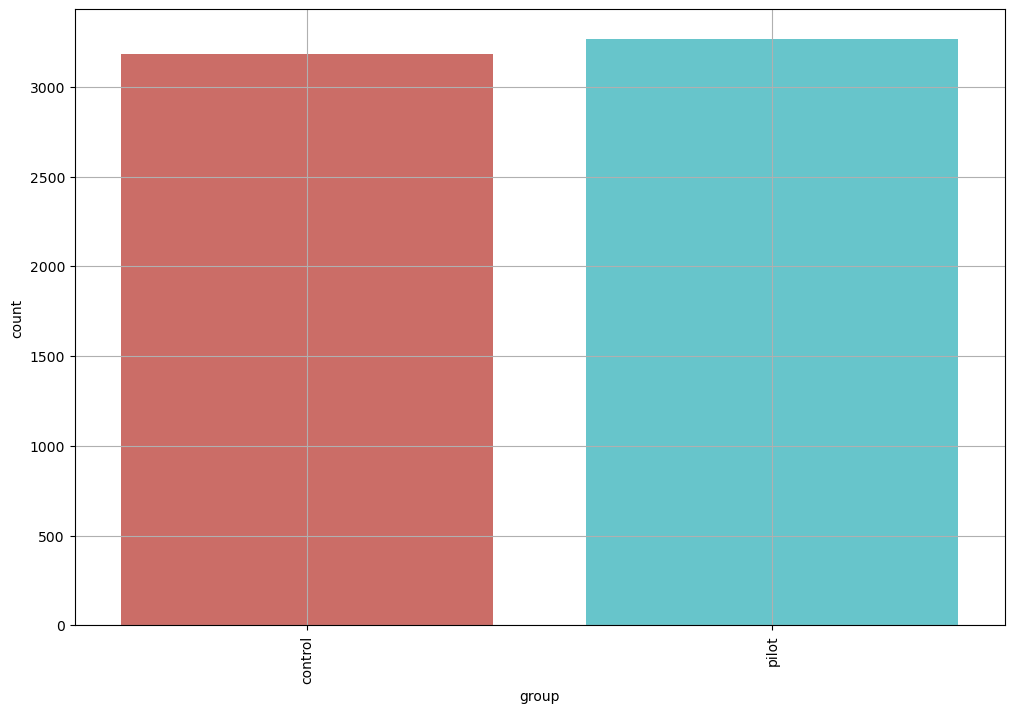

In [7]:
sns.countplot(x='group', data=data, legend=False, palette='hls')
plt.xticks(rotation=90)
plt.grid()

# Дашбоард эксперемента

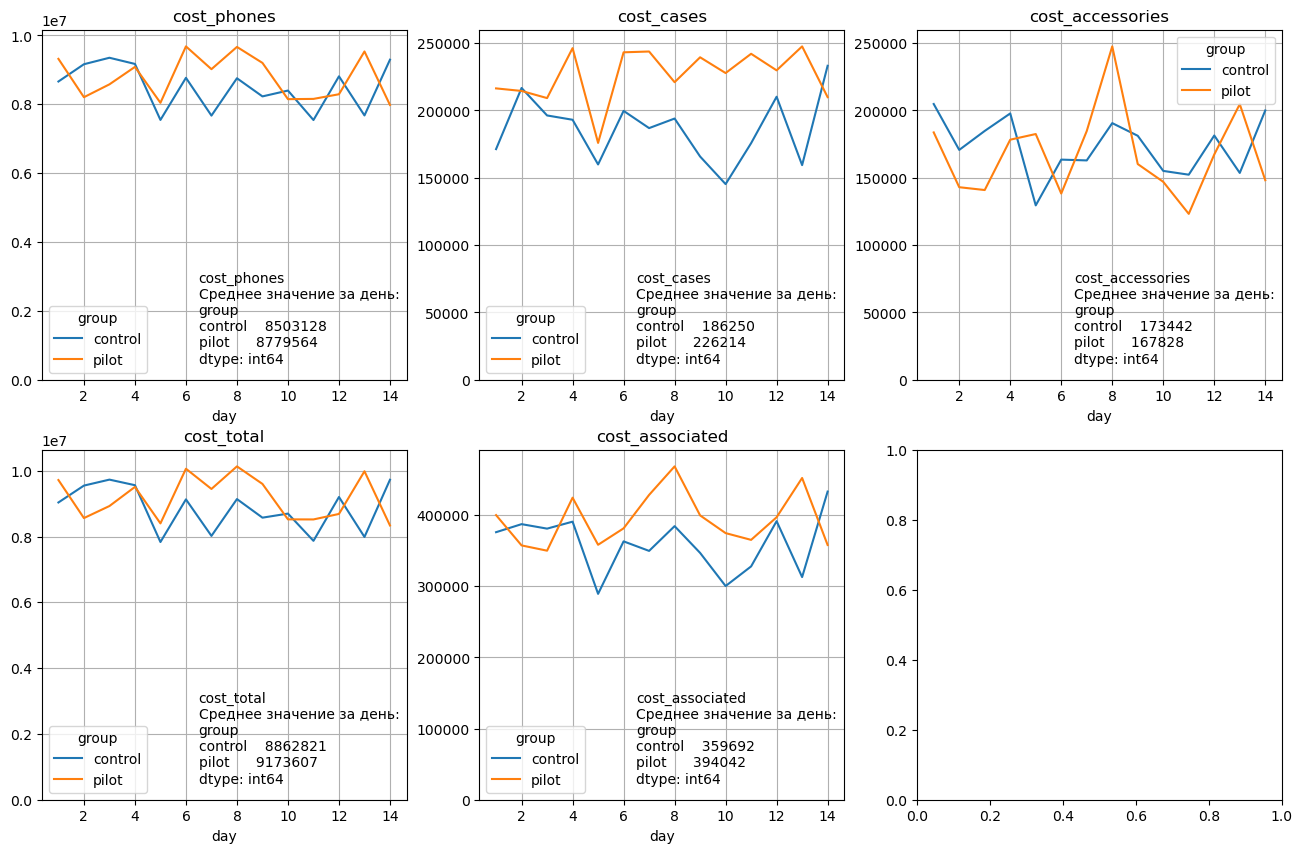

In [8]:
data_sint = data.copy()
data_sint['cost_total'] = data[['cost_phones', 'cost_cases', 'cost_accessories']].sum(axis=1)
data_sint['cost_associated'] = data[['cost_cases', 'cost_accessories']].sum(axis=1)
cost_columns = [c for c in data_sint.columns if 'cost' in c]

fig, ax = plt.subplots(2, 3, figsize=(16, 10))

for column, ax in zip(cost_columns, ax.flatten()): 
    data_groupby = data_sint.groupby(['day', 'group'])[[column]].sum().reset_index()
    data_pivot = data_groupby.pivot(index='day', columns='group', values=column)
    data_pivot.plot(ax=ax, grid=True)
    ax.set_title(column)
    y_max = data_groupby[column].max()
    ax.set_ylim([0, y_max * 1.05])
    annotation = f'{column}\nСреднее значение за день:\n{data_pivot.mean().astype(int)}'
    ax.text(6.5, .05 * y_max, annotation)

# Визуальное сравнение распределений
Давайте немного подробновлсей посмотрим на статистики. Для этого построим гистограммы по всем метрикам.

In [9]:
print(data['group'].value_counts(), '\n')

for column in data.drop('group', axis=1).columns:
    print(column)
    for group in ['control', 'pilot']:
        data_ = data[data['group'] == group][column]
        print(' ', round(data_.mean(), 2), data_.nunique(), data_.min(), data_.max())

pilot      3267
control    3185
Name: group, dtype: int64 

day
  7.41 14 1 14
  7.46 14 1 14
cost_phones
  37376.39 724 4100 100800
  37622.87 735 4100 104100
cost_cases
  818.68 36 0 4200
  969.39 38 0 4000
cost_accessories
  762.39 55 0 6500
  719.19 57 0 6300


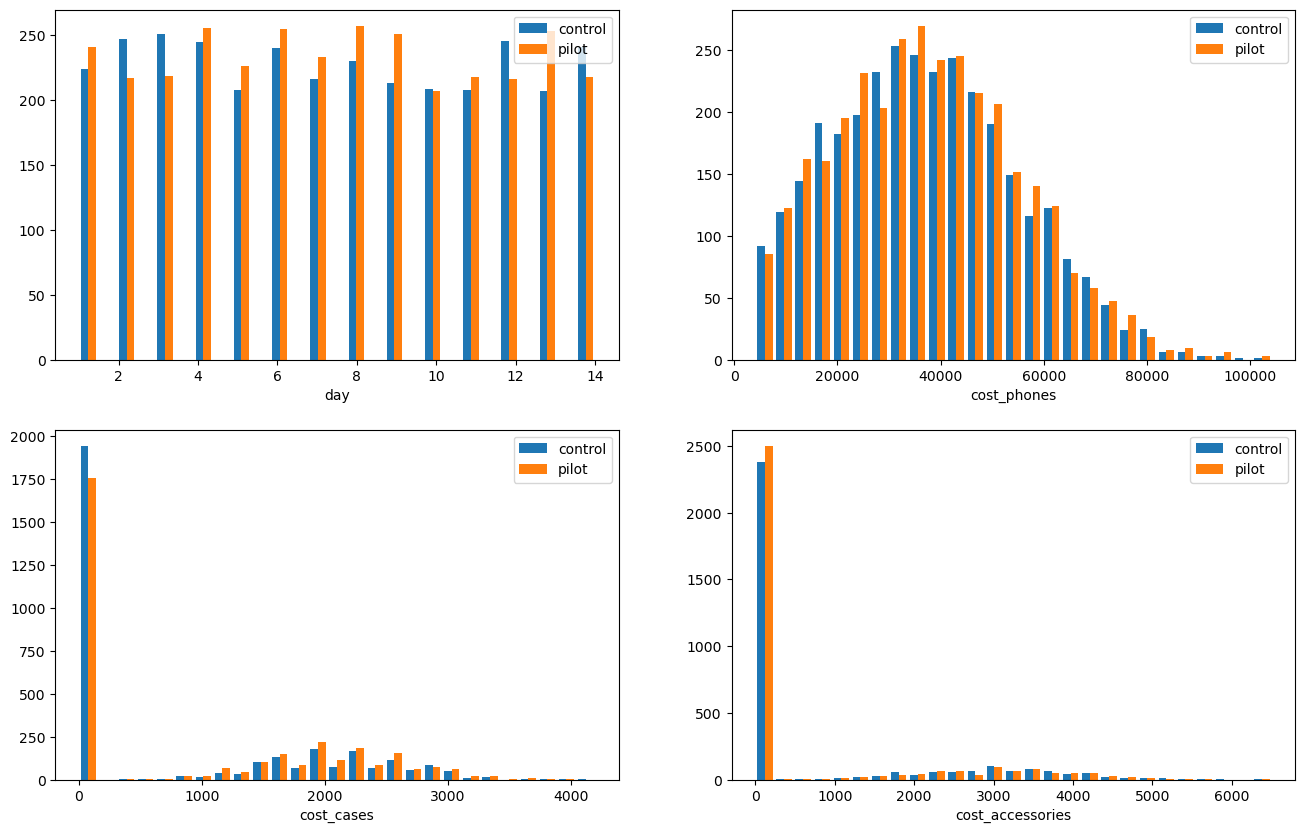

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for column, ax in zip(data.drop('group', axis=1).columns, 
                     ax.flatten()):
    ax.set_xlabel(column)
    data_pilot = data[data['group'] == 'pilot'][column].values
    data_control = data[data['group'] == 'control'][column].values
    bins = np.linspace(data[column].min(), data[column].max(), 28)
    ax.hist([data_control, data_pilot], bins, label=['control', 'pilot'])
    ax.legend()

# Вычисление метрик
Для группировки данных нам понадобится функция pandas.DataFrame.groupby,
а для сбора аггрегированной статистики можно воспользоваться pandas.DataFrame.aggregate

In [11]:
data_grouped = data.groupby('group').agg(
    traffic = ('group', 'count'),
    revenue_phones = ('cost_phones', 'sum'),
    revenue_cases = ('cost_cases', 'sum'),
    revenue_accesssories = ('cost_accessories', 'sum')
)
data_grouped

,traffic,revenue_phones,revenue_cases,revenue_accesssories
group,,,,
control,3185,119043800,2607500,2428200
pilot,3267,122913900,3167000,2349600


<Axes: >

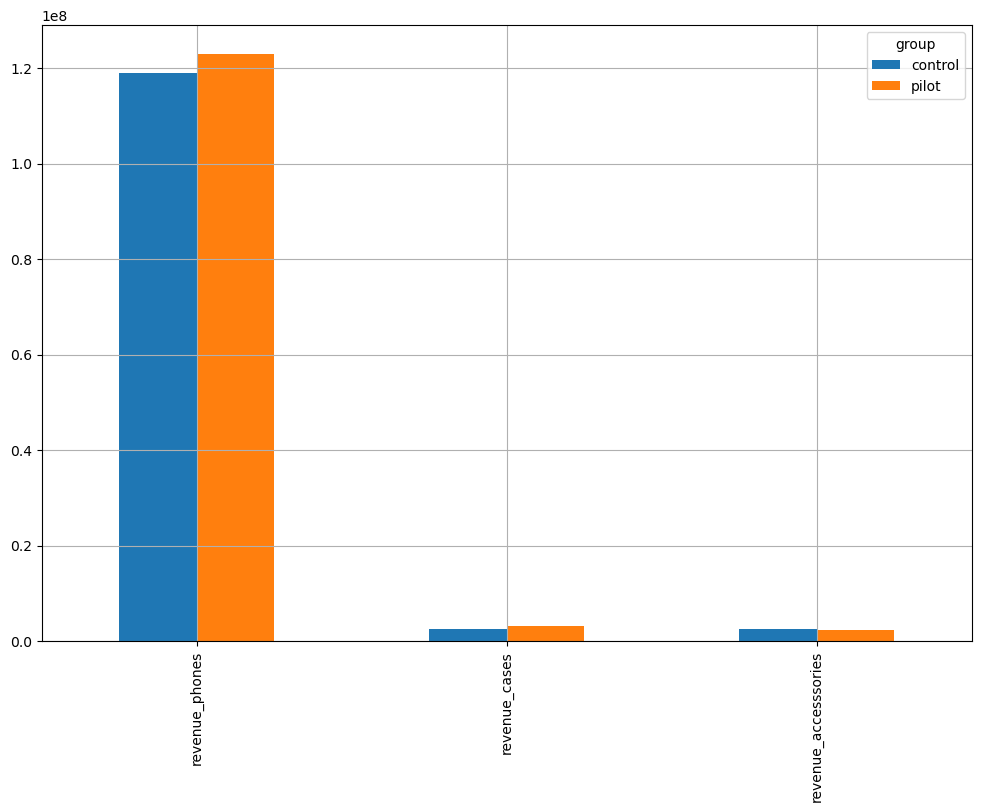

In [12]:
revenue = data_grouped[[col for col in data_grouped.columns if 'revenue' in col]].T
revenue.plot(kind='bar', grid=True)

<Axes: >

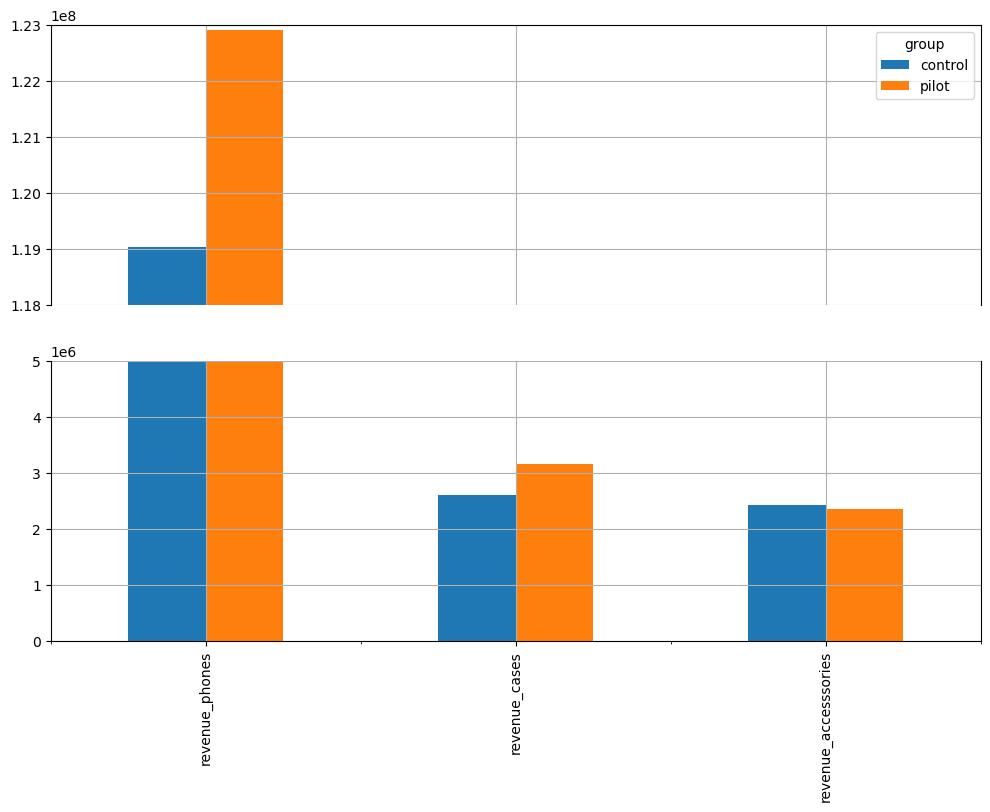

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x', which='both', bottom=False)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 5 * 10 ** 6)
ax1.set_ylim(118 * 10 ** 6, 123 * 10 ** 6)

revenue.plot(ax=ax1, kind='bar', grid=True)
revenue.plot(ax=ax2, kind='bar', legend=False, grid=True)

In [14]:
data_sint.groupby('group')[cost_columns].mean().astype(int)

,cost_phones,cost_cases,cost_accessories,cost_total,cost_associated
group,,,,,
control,37376,818,762,38957,1581
pilot,37622,969,719,39311,1688


# Проверка статистической значимости

In [15]:
GROUP_SIZE = 110_523

for column in cost_columns:
    print(column)
    a_values_nonzero = data_sint[data_sint['group'] == 'control'][column].values
    b_values_nonzero = data_sint[data_sint['group'] == 'pilot'][column].values

    a_values = np.zeros(GROUP_SIZE)
    b_values = np.zeros(GROUP_SIZE)
    a_values[:len(a_values_nonzero)] = a_values_nonzero
    b_values[:len(b_values_nonzero)] = b_values_nonzero

    delta = b_values.mean() - a_values.mean()
    _, pvalue = stats.ttest_ind(a_values, b_values)
    print(f'  delta = {round(delta, 2)}')
    print(f'  pvalue = {round(pvalue, 3)}', '- значимо' if pvalue < .05 else '') 

cost_phones
  delta = 35.02
  pvalue = 0.24 
cost_cases
  delta = 5.06
  pvalue = 0.0 - значимо
cost_accessories
  delta = -0.71
  pvalue = 0.533 
cost_total
  delta = 39.37
  pvalue = 0.202 
cost_associated
  delta = 4.35
  pvalue = 0.013 - значимо


Получили, что целевая метрика статистически значимо увеличилась. Большинство контрольных метрик
согласуются с гипотезой.

# 2. Синтетические метрики - прогнозирование LTV

*Гипотеза*

1. изменили рекламный контент
2. это привлечёт пользователей, с большим LTV
3. мы сможем это измерить по увеличившемуся значению прогноза LTV

Ждать три месяца, чтобы посчитать реальный LTV мы не можем, это очень долго. Поэтому, будем предсказывать LTV по
информации, накопленной о пользователях за первую неделю использования приложения.

*Пилот*

 * случайно разбиваем пользователей, которым показывается реклама, в контрольную или пилотную группы
 * в контрольной группе показываем старую рекламу, в пилотной - новую
 * ждем когда наберется по 100 000 показов
 * конверсия в установки примерно 5%

In [16]:
URL_BASE = 'https://raw.githubusercontent.com/statistics-datasets/kc/main/'

def read_database(file_name):
    return pd.read_csv(URL_BASE + file_name)
    
data_train_model = read_database('sem2_task2_train_model.csv')
data_control = read_database('sem2_task2_control.csv')
data_pilot = read_database('sem2_task2_pilot.csv')

dict_data = {
    'data_train_model': data_train_model,
    'data_control': data_control,
    'data_pilot': data_pilot
}

In [17]:
for key, df in dict_data.items():
    print(f'\n.                   {key}.shape - {df.shape}')
    print(df.head())


.                   data_train_model.shape - (9871, 6)
   sale_first_week  game_time  game_days  bin_one  bin_two         ltv
0       234.202634        108          4        1        1  320.481732
1         0.000000         64          5        1        1   14.444559
2       100.708404         59          4        0        2  143.643114
3        73.543543        100          3        1        2  107.453755
4       168.911308         25          5        1        1  233.867330

.                   data_control.shape - (4942, 5)
   sale_first_week  game_time  game_days  bin_one  bin_two
0          0.00000         77          4        1        2
1         55.97303        107          4        1        2
2          0.00000        103          4        0        3
3          0.00000         36          4        0        2
4          0.00000         69          5        0        2

.                   data_pilot.shape - (4975, 5)
   sale_first_week  game_time  game_days  bin_one  bin_two
0  

In [18]:
data_train_model.describe()

,sale_first_week,game_time,game_days,bin_one,bin_two,ltv
count,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000,9871.000000
mean,73.779144,70.366528,4.207578,0.544220,1.491237,117.909658
std,82.655603,28.806035,1.284767,0.498066,0.865352,108.966714
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,50.000000,3.000000,0.000000,1.000000,22.269550
50%,46.185588,70.000000,4.000000,1.000000,1.000000,80.436254
75%,140.229993,90.000000,5.000000,1.000000,2.000000,204.276274
max,376.595154,171.000000,7.000000,1.000000,3.000000,512.356259


# Корреляция
Мы должны проверить гипотезу о связи ltv с покупками в первую неделю. Для этого иожно рассмотреть корреляцию
между ltv и остальными параметрами:

In [19]:
data_train_model.corrwith(data_train_model['ltv'])

sale_first_week    0.993046
game_time          0.010494
game_days          0.021826
bin_one           -0.001473
bin_two            0.005731
ltv                1.000000
dtype: float64

Мы видим, что корреляция между продажами в первую неделю и ltv близка к единице, это позволяет нам строить линейный
прогноз. В целом же распределение продаж в первую неделю выглядит следующим образом:

<Axes: ylabel='Frequency'>

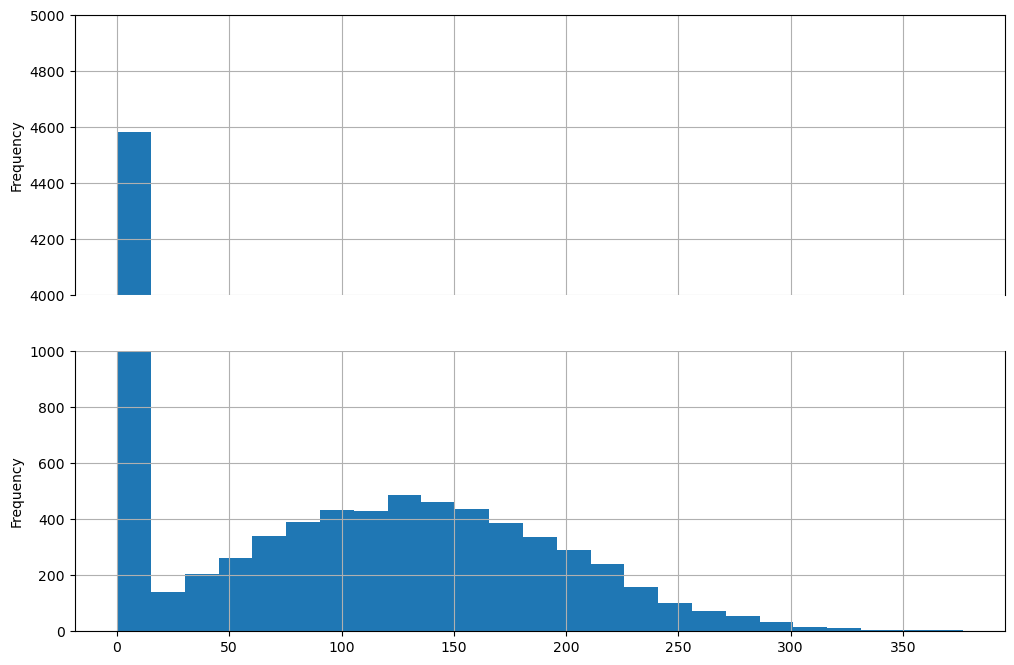

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x', which='both', bottom=False)
ax2.spines['top'].set_visible(False)
ax2.set_ylim(0, 1000)
ax1.set_ylim(4000, 5000)

data_train_model['sale_first_week'].plot(ax=ax1, kind='hist', bins=25, grid=True)
data_train_model['sale_first_week'].plot(ax=ax2, kind='hist', bins=25, grid=True)

# Совместное распределение
Мы можем посмотреть как величины совместно распределены. Для этого можно построить парные диаграммы рассеяния.

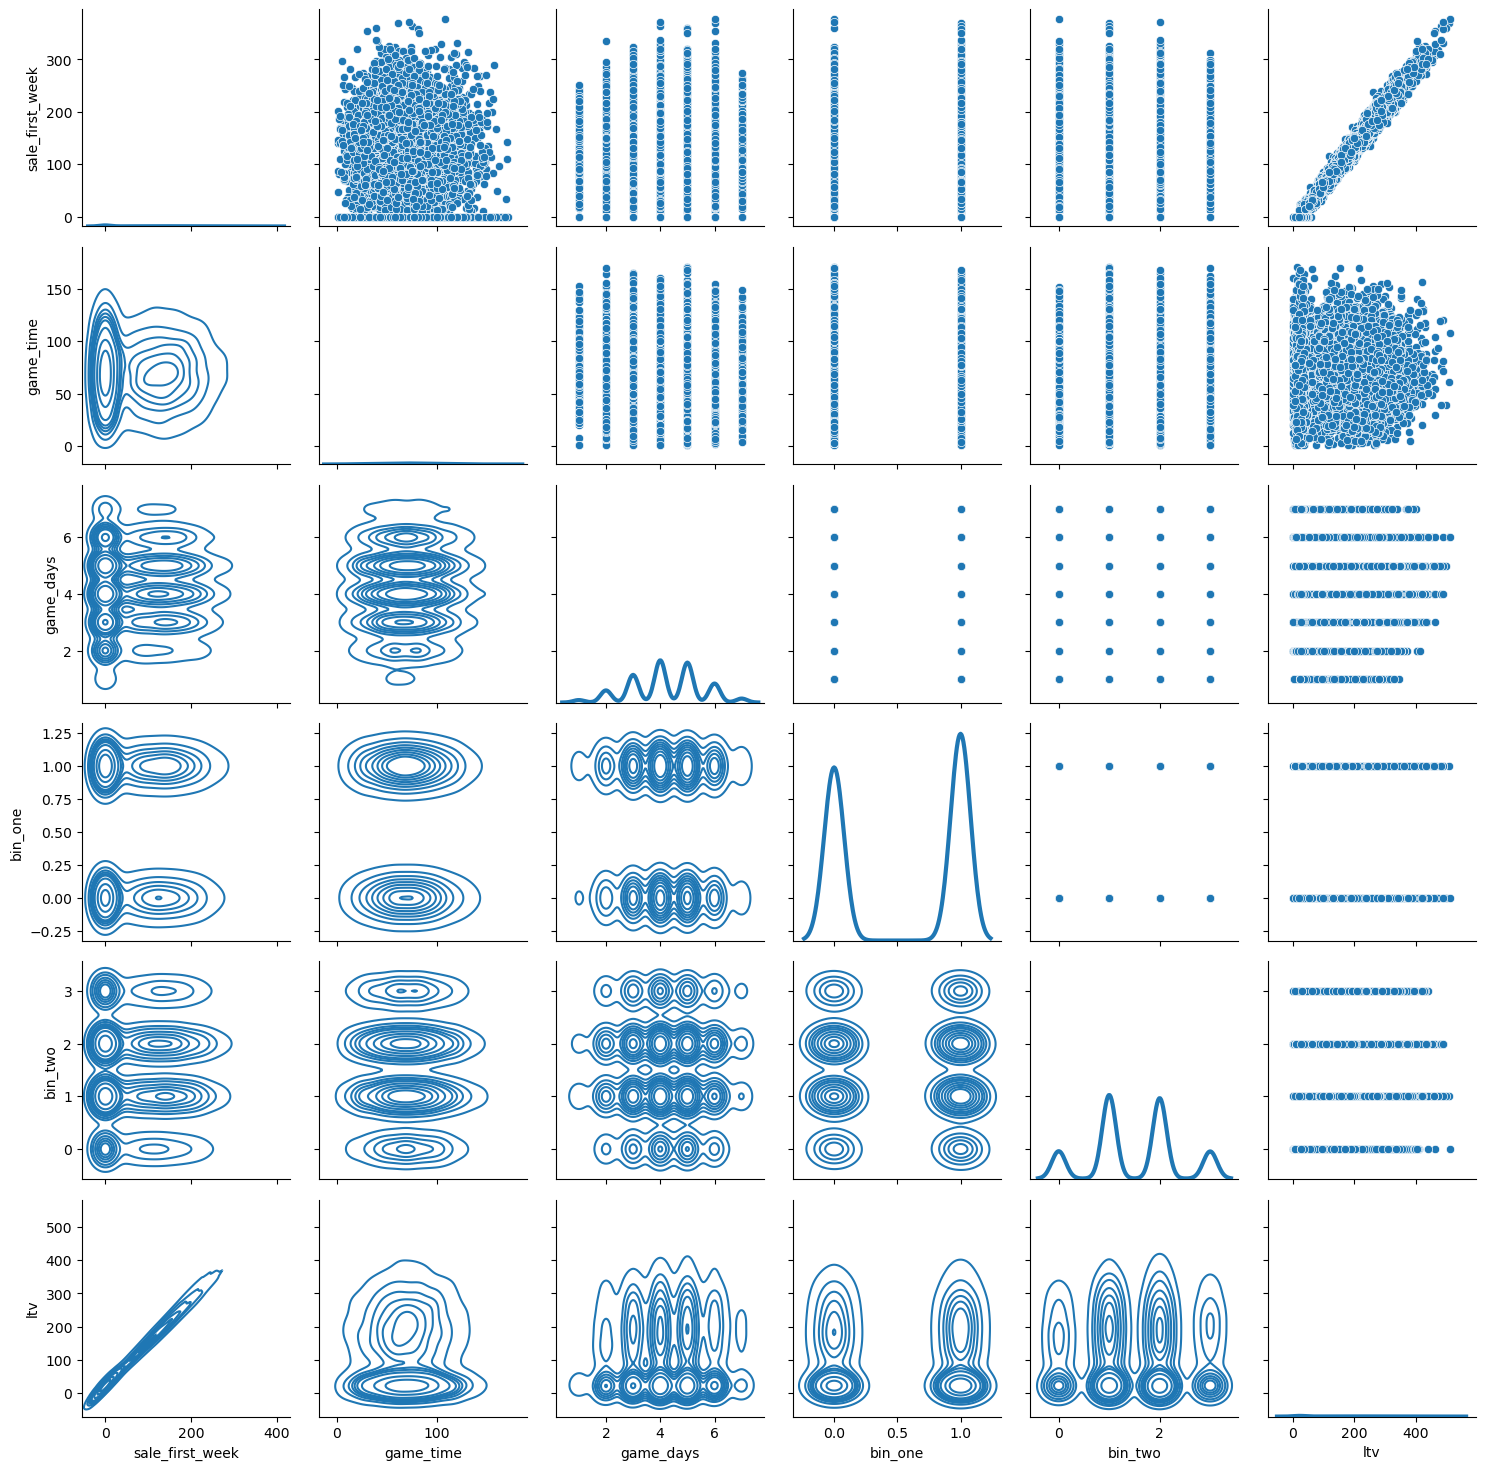

In [21]:
g = sns.PairGrid(data_train_model)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False);

# Сравнение параметров в контрольной и пилотной группах

In [22]:
for column in data_control.columns:
    print(column)
    delta = data_pilot[column].mean() - data_control[column].mean()
    _, pvalue = stats.ttest_ind(data_control[column], data_pilot[column])
    print(f'   delta = {round(delta, 4)}')
    print(f'   pvalue = {round(pvalue, 4)}', '- значимо' if pvalue < .05 else '')

sale_first_week
   delta = 3.1515
   pvalue = 0.0548 
game_time
   delta = 9.8927
   pvalue = 0.0 - значимо
game_days
   delta = 0.3403
   pvalue = 0.0 - значимо
bin_one
   delta = -0.2081
   pvalue = 0.0 - значимо
bin_two
   delta = 0.5794
   pvalue = 0.0 - значимо


Видно, что параметры привлекаемых пользователей значимо изменились в пилотной группе. Хотя отличие наиболее
скоррелированного с LTV параметра sale_first_week изменилось не статистически значимо.

# Обучение модели

In [23]:
np.random.seed(2021)
train, test = train_test_split(data_train_model, test_size=.2)


def train_model(features, train, test, verbose=True):
    model = RidgeCV(alphas=np.logspace(-8, 1, 10), cv=5)
    model.fit(train[features], train['ltv'])
    score = model.score(test[features], test['ltv'])
    if verbose:
        print(f'features == {features}\tscore = {round(score, 5)}')

    return {'model': model, 'features': features, 'score': score}

features1 = ['sale_first_week', 'game_time', 'game_days']
features2 = ['sale_first_week', 'game_time', 'game_days', 'bin_one', 'bin_two']
features3 = ['sale_first_week', 'game_days', 'bin_one', 'bin_two']
features4 = ['sale_first_week', 'game_time', 'bin_one', 'bin_two']

trained_models = []

for features in [features1, features2, features3, features4]:
    trained_models.append(train_model(features, train, test))

features == ['sale_first_week', 'game_time', 'game_days']	score = 0.98696
features == ['sale_first_week', 'game_time', 'game_days', 'bin_one', 'bin_two']	score = 0.98705
features == ['sale_first_week', 'game_days', 'bin_one', 'bin_two']	score = 0.98699
features == ['sale_first_week', 'game_time', 'bin_one', 'bin_two']	score = 0.98656


Качество моделей получилось довольно хорошим. Сделаем прогнозы на данных пилотной и контрольной групп и сравним
полученные прогнозные значения LTV для лучшей из наших моделей. Учтем, что это реклама показывалась 100 000 пользователей,
все кто не устанавливал приложение заменены нулями.

In [24]:
trained_models.sort(key=lambda x: -x['score'])

def predict_and_calculate_ttest(model_and_properties, data_control, data_pilot):
    model = model_and_properties['model']
    features = model_and_properties['features']
    predict_control = model.predict(data_control[features])
    predict_pilot = model.predict(data_pilot[features])

    control_values = np.zeros(100_000)
    pilot_values = np.zeros(100_000)

    control_values[:len(predict_control)] = predict_control
    pilot_values[:len(predict_pilot)] = predict_pilot

    delta = pilot_values.mean() - control_values.mean()
    _, pvalue = stats.ttest_ind(control_values, pilot_values)

    print(f'delta = {round(delta, 4)}')
    print(f'pvalue = {round(pvalue, 4)}')

    return delta, pvalue

predict_and_calculate_ttest(trained_models[0], data_control, data_pilot)

delta = 0.3479
pvalue = 0.0289


(0.347871752910077, 0.0288940063917947)

In [25]:
for trained_model in trained_models[1:]:
    print(f'\n\nfeatures : {trained_model["features"]}')
    predict_and_calculate_ttest(trained_model, data_control, data_pilot)



features : ['sale_first_week', 'game_days', 'bin_one', 'bin_two']
delta = 0.3267
pvalue = 0.04


features : ['sale_first_week', 'game_time', 'game_days']
delta = 0.2952
pvalue = 0.063


features : ['sale_first_week', 'game_time', 'bin_one', 'bin_two']
delta = 0.3187
pvalue = 0.045


In [26]:
p_vals = []

for _ in range(1000):
    # random_time_interval
    # random_a_b
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0, 1, 100)
    _, p_val = ttest_ind(a, b)
    p_vals.append(p_val)

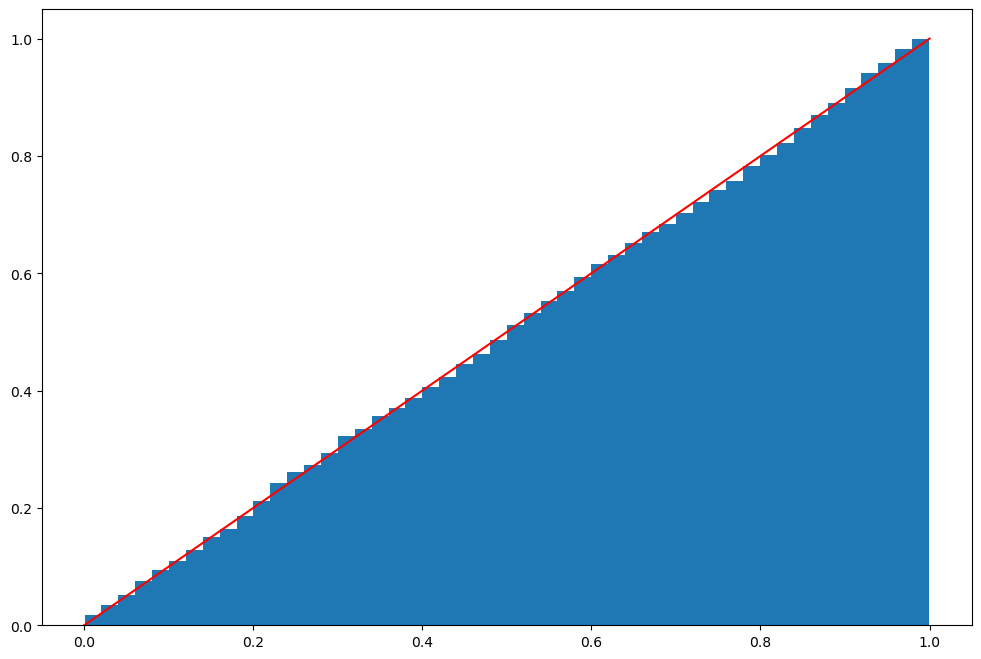

In [29]:
plt.hist(p_vals, cumulative=True, density=True, bins=50)
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), c='r');